# 0.8.1 Hierarchical DQ Learning

Quickly put together a reinforcement learning how DQNs perform when run on tasks with a hierarchical structure such as the one laid out in [this](http://ski.clps.brown.edu/papers/CollinsFrank_Cognition.pdf) paper.

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [35]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Thu Jun 13 2019 00:56:49 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.2
seaborn 0.9.0
tensorflow 1.10.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.18.0-21-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 9b138876ec01744f4f4b303641c4f9be4079437e
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode.
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [36]:
# Standard library imports
import logging
import os
from pathlib import Path
from copy import deepcopy
from pprint import pprint

# Third party
import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pstar import pdict

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [5]:
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
%aimport leabratf.constants
from leabratf.constants import DIR_DATA_PROC

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()
sns.set_context("notebook")

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [7]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger('leabratf')

## Task Definitions

### Constants

In [8]:
N_COLORS = 5
N_SHAPES = 4
N_ACTIONS = 4

### Phase Colors and Shapes

In [149]:
# All the colors and shapes
all_colors = [0, 1, 2, 3, 4]
all_shapes = [1 ,2, 3, 4]

# Phase A
phase_a_colors = [0, 1, 2, 2]
phase_a_shapes = [1, 2]

# Phase B
phase_b_colors = [0, 1, 2, 2]
phase_b_shapes = [3, 4]

# Phase C
phase_c_colors = [3, 4]
phase_c_shapes = [3, 4]

# Phase Pairs
phase_color_shape_pairs = {
    'Phase A' : (phase_a_colors, phase_a_shapes),
    'Phase B' : (phase_b_colors, phase_b_shapes),
    'Phase C' : (phase_c_colors, phase_c_shapes),
}

# Color lines correspond to a particular horizontal line
# # colors are not uniformly selected for
# Shapes corespond to a particular vertical line
# Color, Shape combinations correspond to a particular action 1-4

### Task-Sets

In [29]:
# Define the constants
# TS Colors
ts1_colors = [0, 1]
ts2_colors = [2]
ts_old_colors = [3]
ts_new_colors = [4]

ts_color_shape_pairs = {
    'TS 1 Phase A' : (ts1_colors, phase_a_shapes),
    'TS 2 Phase A' : (ts2_colors, phase_a_shapes),
    'TS 1 Phase B' : (ts1_colors, phase_b_shapes),
    'TS 2 Phase B' : (ts2_colors, phase_b_shapes),
    'TS Old Phase C' : (ts_old_colors, phase_c_shapes),
    'TS New Phase C' : (ts_new_colors, phase_c_shapes),
}

### Action Mapping

In [22]:
action_dictonary_ts1 = {
    # (Color, Shape) : Action
    #      Phase A       |       Phase B
    (0,1) : 1, (0,2) : 2, (0,3) : 1, (0,4) : 3, # TS 1
    (1,1) : 1, (1,2) : 2, (1,3) : 1, (1,4) : 3, # TS 1
    (2,1) : 3, (2,2) : 4, (2,3) : 4, (2,4) : 2, # TS 2
    #                    |       Phase C
                          (3,3) : 1, (3,4) : 3, # TS Old
                          (4,3) : 1, (4,4) : 2} # TS New

In [23]:
action_dictonary_ts2 = {
    # (Color, Shape) : Action
    #      Phase A       |       Phase B
    (0,1) : 1, (0,2) : 2, (0,3) : 1, (0,4) : 3, # TS 1
    (1,1) : 1, (1,2) : 2, (1,3) : 1, (1,4) : 3, # TS 1
    (2,1) : 3, (2,2) : 4, (2,3) : 4, (2,4) : 2, # TS 2
    #                    |       Phase C
                          (3,3) : 4, (3,4) : 2, # TS Old
                          (4,3) : 1, (4,4) : 2} # TS New

## Data Generation Functions

### Phase Label Generation

In [16]:
def explicit_phase_labels(phase_colors,
                          phase_shapes,
                          n_colors=N_COLORS,
                          n_shapes=N_SHAPES,
                         ):
    # Meshgrid across the colors and shapes
    choices = np.array(np.meshgrid(phase_colors, phase_shapes)).T.reshape(-1,2)
    # Turn them into one hot vectors
    color_choices = np.eye(n_colors)[choices[:,0]]
    shape_choices = np.eye(n_shapes)[choices[:,1] - 1]
    # Reshape to the desired shape
    color_choices = color_choices.reshape((len(color_choices), n_colors, 1))
    shape_choices = shape_choices.reshape((len(shape_choices), n_shapes, 1))
    
    return color_choices, shape_choices

### Action Selection

In [24]:
def actions(color_choices, shape_choices, action_dict=action_dictonary_ts1, 
            n_actions=N_ACTIONS):
    """Implements the mapping from shapes and colors to actions"""
    # Make binary from one hot and increment shape by 1
    color_binarized = integer_labels(color_choices)
    shape_binarized = [i+1 for i in integer_labels(shape_choices)]
    # Compile into a list of tuples
    label_tuples = [(color, shape) for color, shape in zip(
        color_binarized, shape_binarized)]
    # Substitute based on the action dictionary
    integer_actions = [action_dict[key] for key in label_tuples]
    return np.eye(n_actions)[np.array(integer_actions)-1]

### Helper Functions

In [154]:
def integer_labels(labels):
    """Turns one-hot labels to integers"""
    return [np.where(r==1)[0][0] for r in labels]
    
def input_array(color_choices, shape_choices, 
                n_shapes=N_SHAPES, n_colors=N_COLORS):
    """Turns one-hot labels to 2D input arrays with lines"""
    # Full Color array
    color_array = np.tile(color_choices, n_shapes)
    # Full Shape Array
    shape_array = np.transpose(
        np.tile(shape_choices, n_colors),
        [0, 2, 1])
        
    # Full data with both
    x_data = np.maximum(color_array, shape_array)
    return x_data

## Making the Datasets

### Generating the Phase Data

In [155]:
phase_datasets = {}
for phase, phase_pair in phase_color_shape_pairs.items():
    choices = explicit_phase_labels(*phase_pair)
    inputs = input_array(*choices)
    labels = actions(*choices)
    phase_datasets[phase] = (inputs, labels)

### Generating the Task-Set Datasets

In [156]:
ts_datasets = {}
for ts, ts_pair in ts_color_shape_pairs.items():
    choices = explicit_phase_labels(*ts_pair)
    inputs = input_array(*choices)
    labels = actions(*choices)
    ts_datasets[ts] = (inputs, labels)

### Tensorflow Datasets

In [157]:
def make_tf_ts_datasets(datasets, init_ops=None):
    # The first step of the setup is that each of the datasets (training, validation, and 
    # testing) are turned into their own `Dataset` objects.
    tf_datasets = pdict()
    for data, name in zip(datasets, ['train', 'ts']):
        for key in data.keys():
            tf_datasets[key] = tf.data.Dataset.from_tensor_slices(
                data[key]).repeat().shuffle(len(data[key][0])).batch(
                1 if name=='train' else len(data[key][0]))
    
    # Next, let's define the iterators for each of the datasets, and then add their 
    # initializations to the `init_ops` list.
    # Training iterator
    iterators = pdict({name : data.make_initializable_iterator()
                      for name, data in tf_datasets.items()})

    # Add the initiatlizations to the init opts
    init_ops = init_ops or []
    init_ops += [iter.initializer for iter in iterators.values()]
    
    first_dataset = list(tf_datasets.values())[0] 
    output_types, output_shapes = first_dataset.output_types, first_dataset.output_shapes
    
    # And finally, the interesting part. Rather than creating separate next elements for 
    # the model, the `tf.data` API has a string handler iterator so we can contextually 
    # switch the active `Dataset` object, resulting in different values being used for `x` 
    # and `y`.

    # The way this is done is by defining a `tf.placeholder` variable, which is used 
    # first to create a string handler iterator, and later to hold the dataset-indicating 
    # string handle. The string handler iterator is what then changes the values of `x` and 
    # `y`, naturally also supplying them using the `get_next` method.
    # The placeholder variable of type string
    handle = tf.placeholder(tf.string, shape=[])
    
    # Iterator from string handle
    handle_iterator = tf.data.Iterator.from_string_handle(
        handle, output_types, output_shapes)

    # x and y that will be used in the graph
    x, y = handle_iterator.get_next()
    
    return x, y, iterators, handle, init_ops

## Recreating Old Plots

In [158]:
N_INPUTS = N_COLORS * N_SHAPES
N_HIDDEN_1 = 100 
N_OUTPUTS = 4
TF_DEVICE = '/device:CPU:0'

### Oreilly Model

In [159]:
def oreilly_model(inputs):
    # Reshape for hidden layer
    inputs = tf.reshape(inputs, shape=[-1, N_INPUTS])
    # Single hidden layer
    inputs = tf.sigmoid(tf.add(tf.matmul(inputs, weights['h1']), biases['b1']))
    # Output layer
    inputs = tf.add(tf.matmul(inputs, weights['out']), biases['out'])
    # Reshape for labels
    return tf.reshape(inputs, shape=[-1, N_OUTPUTS])

### Main Graph Definitions

In [160]:
# Cleanup any residual nodes
tf.reset_default_graph()
init_ops = []

# Weights and biases
weights = pdict({
    'h1': tf.get_variable(
        name='w_h1', 
        shape=[N_INPUTS, N_HIDDEN_1],
        initializer=tf.contrib.layers.xavier_initializer(),
        dtype=tf.float64),
    'out': tf.get_variable(
        name='w_out', 
        shape=[N_HIDDEN_1, N_OUTPUTS],
        initializer=tf.contrib.layers.xavier_initializer(),
        dtype=tf.float64),
})
biases = pdict({
    'b1': tf.get_variable(
        name="b_1", 
        shape=[N_HIDDEN_1], 
        initializer=tf.zeros_initializer(),
        dtype=tf.float64),
    'out': tf.get_variable(
        name="b_out", 
        shape=[N_OUTPUTS], 
        initializer=tf.zeros_initializer(),
        dtype=tf.float64),
})

with tf.device(TF_DEVICE):
    # Get the relevant dataset nodes
    x, y, iterators, handler, init_ops = make_tf_ts_datasets(
        (phase_datasets, ts_datasets), init_ops)

    # Build the model
    logits = oreilly_model(x)
    # Ensure y is cast to the same type as logits
    labels = tf.cast(y, logits.dtype)
    
    # We will keep this in for now
    # Define alpha as placeholder variable
    alpha_ph = tf.placeholder(tf.float32, shape=[])

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.losses.softmax_cross_entropy(
        labels, logits))

    # Define some intermediate nodes
    predictions = tf.nn.softmax(logits)
    rounded_predictions = tf.round(predictions)
    equal_labels_and_preds = tf.equal(rounded_predictions, labels)
    
    # Accuracy 
    sample_acc = tf.reduce_all(equal_labels_and_preds, axis=1)
    accuracy = tf.reduce_mean(tf.cast(sample_acc, tf.float64))
 
    # Adam
    train_op_adam = tf.train.AdamOptimizer(alpha_ph).minimize(loss_op)
    # Adadelta 
    train_op_adadelta = tf.train.AdadeltaOptimizer(alpha_ph).minimize(loss_op)
    # RMSProp
    train_op_rmsprop = tf.train.RMSPropOptimizer(alpha_ph).minimize(loss_op)
    # SGD
    train_op_sgd = tf.train.GradientDescentOptimizer(alpha_ph).minimize(loss_op)
    
# And now add these to a dictionary
optimizer_dict = pdict({
    'Adam' : train_op_adam,
    'Adadelta' : train_op_adadelta,
    'RMSProp' : train_op_rmsprop,
    'sgd' : train_op_sgd,
})

### TF Helper Functions

In [161]:
def new_session(*args, **kwargs):
    # Try to close the globally defined session if it isn't already
    try:
        if not sess._closed:
            sess.close()
    # If it doesn't exist, then just pass
    except NameError:
        pass
    # Return the new instance
    return tf.Session(*args, **kwargs)

In [162]:
# Based on code from 
# https://codereview.stackexchange.com/questions/169870/decorator-to-measure-execution-time-of-a-function
from functools import wraps
from time import time
import datetime

def timing(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time()
        result = func(*args, **kwargs)
        end = time()
        logger.info('Elapsed time: {}'.format(
            datetime.timedelta(seconds=end-start)))
        return result
    return wrapper

### Training Function

In [163]:
@timing
def train_exp(
    sess, 
    lr=0.0033, 
    epochs=100,
    train_op=optimizer_dict['Adam'], 
    init_ops=None,
    verbose=False,
    phases=['a'],
    n_train=None,
    n_val=5,
):
    log_level = logger.info if verbose else logger.debug
    log_level(f'Beginning training using learning rate {lr}, {train_op.name} '
              f'training routine, for {epochs} epochs')
    # Ensure this is an int
    epochs = int(epochs)
    # Dict with the various metrics we care about while training
    phase_metrics = pdict()
    
    # Run the initialization ops
    init_ops = init_ops or []
    if tf.global_variables_initializer() not in init_ops:
        init_ops += [tf.global_variables_initializer(), 
                     tf.local_variables_initializer()]
    sess.run(init_ops)
    
    # Define training and validation handlers
    handles = pdict({name : sess.run(iterators[name].string_handle())
                    for name in iterators.keys()})
    
    for i, phase in enumerate(phases):
        n_train = len(phase_datasets[phase][0])
        epoch_metrics = pdict(
            {key : pdict({'loss':[], 'accuracy':[]})
             for key in ts_datasets.keys()})
        epoch_metrics['encounter'] = []
        training_metrics = pdict(
            {key : pdict({'loss':[], 'accuracy':[]})
             for key in ts_datasets.keys()})
        
        for epoch in range(epochs):
            for _ in range(n_train):
                # Training op and compute metrics
                _ = sess.run(
                    train_op, 
                    feed_dict={alpha_ph: lr, handler: handles[phase]})
                
                for met_key in ts_datasets.keys():
                    metrics = sess.run(
                        [loss_op, accuracy],
                        feed_dict={handler: handles[met_key]})
                    # Record
                    for key, metric in zip(['loss', 'accuracy'], metrics):
                        training_metrics[met_key][key].append(metric)

            if not epoch % n_val or epoch == epochs - 1:
                for ts_key in ts_datasets.keys():
                    for metric, values in training_metrics[ts_key].items():
                        epoch_metrics[ts_key][metric].append(np.mean(values))
                epoch_metrics['encounter'].append(epoch + i*epochs)
                log_level(f'Completed Epoch {epoch} for {phase}')
                training_metrics = pdict(
                    {key : pdict({'loss':[], 'accuracy':[]})
                     for key in ts_datasets.keys()})
        
        phase_metrics[phase] = epoch_metrics
        log_level(f'Completed {phase}')

    return phase_metrics

### Running the Experiment

In [ ]:
%%time
N_MODELS = 100
sess = new_session()
all_ts_phase_metrics = [train_exp(
    sess, 
    phases=phase_datasets.keys(),
    lr=0.00333, 
    epochs=25,
    train_op=optimizer_dict['Adam'], 
    init_ops=init_ops,
    verbose=False,
    n_train=None,
    n_val=1,
) for _ in range(N_MODELS)]

### Plotting TS1 for TS Old Data

#### Plotting Functions

In [165]:
def plot_multiple_models(all_ts_phase_metrics, dataset_to_plot, title=None):
    model_average = True
    
    # Empty lists for the long form data
    long_epochs, long_metrics, long_hues, long_units = [], [], [], []

    # Loop through each model's data
    for i, model_metrics in enumerate(all_ts_phase_metrics):
        # Plot the number of epochs according to the data with the shortest
        # number of epochs.
        # Add to the long form lists
        samples = []
        for phase, phase_metrics in model_metrics.items():
            for dataname in dataset_to_plot:
                n_epochs = len(phase_metrics['encounter'])
                label = dataname
                units = i
                long_epochs += phase_metrics['encounter']
                long_metrics += phase_metrics[dataname]['accuracy']
                long_hues += [f'{dataname}']*n_epochs
                long_units += [units]*n_epochs

    if model_average:
        sns.lineplot(x=long_epochs, y=long_metrics, hue=long_hues, 
                     estimator='mean')
    # Plot each line individually
    else:
        sns.lineplot(x=long_epochs, y=long_metrics, hue=long_hues, 
                     estimator=None, units=long_units)

    for vline in [n_epochs, n_epochs*2]:
        plt.axvline(vline, linestyle='--')

    if title:
        plt.title(title)
    plt.xlabel('Number of Phase Encounters')
    plt.ylabel('Accuracy')
    plt.show()

#### Full Plots Using TS1 for TS Old

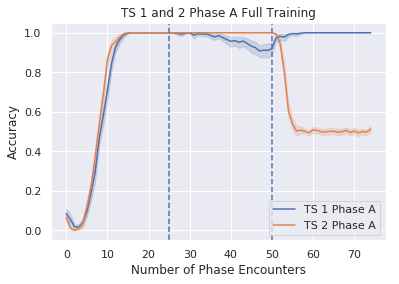

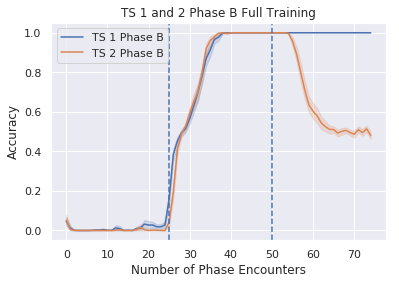

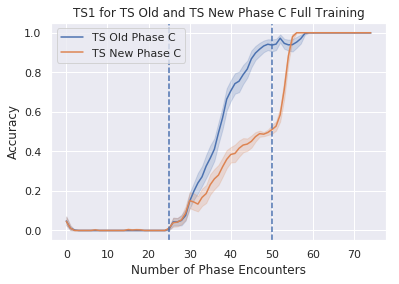

In [166]:
datasets_to_plot = [['TS 1 Phase A', 'TS 2 Phase A'],
                    ['TS 1 Phase B', 'TS 2 Phase B'],
                    ['TS Old Phase C', 'TS New Phase C']]
titles = ['TS 1 and 2 Phase A Full Training',
          'TS 1 and 2 Phase B Full Training',
          'TS1 for TS Old and TS New Phase C Full Training']
for dataset, title in zip(datasets_to_plot, titles):
    plot_multiple_models(all_ts_phase_metrics, dataset,
                         title=title)

### Rerunning TS2 for TS Old

#### Redeclaring Relevant Stuff

In [167]:
phase_datasets_ts2 = {}
for phase, phase_pair in phase_color_shape_pairs.items():
    choices = explicit_phase_labels(*phase_pair)
    inputs = input_array(*choices)
    labels = actions(*choices,
                     action_dict=action_dictonary_ts2)
    phase_datasets_ts2[phase] = (inputs, labels)
    
ts_datasets_ts2 = {}
for ts, ts_pair in ts_color_shape_pairs.items():
    choices = explicit_phase_labels(*ts_pair)
    inputs = input_array(*choices)
    labels = actions(*choices,
                     action_dict=action_dictonary_ts2)
    ts_datasets_ts2[ts] = (inputs, labels)

In [168]:
# Cleanup any residual nodes
tf.reset_default_graph()
init_ops = []

# Weights and biases
weights = pdict({
    'h1': tf.get_variable(
        name='w_h1', 
        shape=[N_INPUTS, N_HIDDEN_1],
        initializer=tf.contrib.layers.xavier_initializer(),
        dtype=tf.float64),
    'out': tf.get_variable(
        name='w_out', 
        shape=[N_HIDDEN_1, N_OUTPUTS],
        initializer=tf.contrib.layers.xavier_initializer(),
        dtype=tf.float64),
})
biases = pdict({
    'b1': tf.get_variable(
        name="b_1", 
        shape=[N_HIDDEN_1], 
        initializer=tf.zeros_initializer(),
        dtype=tf.float64),
    'out': tf.get_variable(
        name="b_out", 
        shape=[N_OUTPUTS], 
        initializer=tf.zeros_initializer(),
        dtype=tf.float64),
})

with tf.device(TF_DEVICE):
    # Get the relevant dataset nodes
    x, y, iterators, handler, init_ops = make_tf_ts_datasets(
        (phase_datasets_ts2, ts_datasets_ts2), init_ops)

    # Build the model
    logits = oreilly_model(x)
    # Ensure y is cast to the same type as logits
    labels = tf.cast(y, logits.dtype)
    
    # We will keep this in for now
    # Define alpha as placeholder variable
    alpha_ph = tf.placeholder(tf.float32, shape=[])

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.losses.softmax_cross_entropy(
        labels, logits))

    # Define some intermediate nodes
    predictions = tf.nn.softmax(logits)
    rounded_predictions = tf.round(predictions)
    equal_labels_and_preds = tf.equal(rounded_predictions, labels)
    
    # Accuracy 
    sample_acc = tf.reduce_all(equal_labels_and_preds, axis=1)
    accuracy = tf.reduce_mean(tf.cast(sample_acc, tf.float64))
 
    # Adam
    train_op_adam = tf.train.AdamOptimizer(alpha_ph).minimize(loss_op)
    # Adadelta 
    train_op_adadelta = tf.train.AdadeltaOptimizer(alpha_ph).minimize(loss_op)
    # RMSProp
    train_op_rmsprop = tf.train.RMSPropOptimizer(alpha_ph).minimize(loss_op)
    # SGD
    train_op_sgd = tf.train.GradientDescentOptimizer(alpha_ph).minimize(loss_op)
    
# And now add these to a dictionary
optimizer_dict = pdict({
    'Adam' : train_op_adam,
    'Adadelta' : train_op_adadelta,
    'RMSProp' : train_op_rmsprop,
    'sgd' : train_op_sgd,
})

In [ ]:
%%time
N_MODELS = 100
sess = new_session()
all_ts_phase_metrics_ts2 = [train_exp(
    sess, 
    phases=phase_datasets.keys(),
    lr=0.00333, 
    epochs=25,
    train_op=optimizer_dict['Adam'], 
    init_ops=init_ops,
    verbose=False,
    n_train=None,
    n_val=1,
) for _ in range(N_MODELS)]

#### Plots for TS2 for TS Old

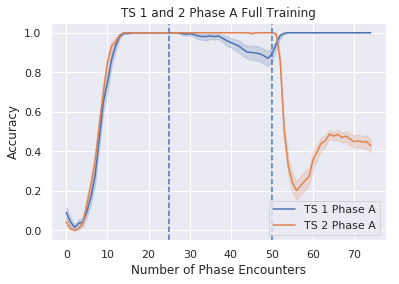

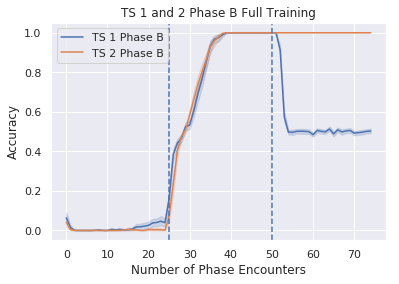

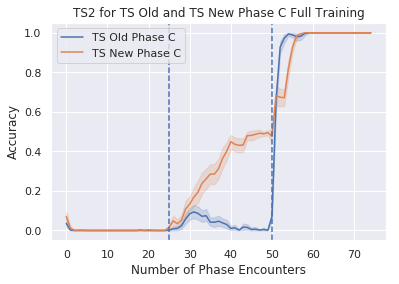

In [170]:
datasets_to_plot = [['TS 1 Phase A', 'TS 2 Phase A'],
                    ['TS 1 Phase B', 'TS 2 Phase B'],
                    ['TS Old Phase C', 'TS New Phase C']]
titles = ['TS 1 and 2 Phase A Full Training',
          'TS 1 and 2 Phase B Full Training',
          'TS2 for TS Old and TS New Phase C Full Training']
for dataset, title in zip(datasets_to_plot, titles):
    plot_multiple_models(all_ts_phase_metrics_ts2, dataset,
                         title=title)